In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving data.csv to data.csv


In [ ]:
df = pd.read_csv("data.csv", encoding="latin-1")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
df.shape

(541909, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
df = df.dropna(subset=['CustomerID'])
df['Description'] = df['Description'].fillna('Unknown')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [ ]:
import datetime as dt

reference_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
print("Reference date:", reference_date)

Reference date: 2011-12-10 12:50:00


In [ ]:
recency = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency['Recency'] = (reference_date - recency['InvoiceDate']).dt.days


In [ ]:
frequency = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
frequency.columns = ['CustomerID', 'Frequency']


In [ ]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
monetary = df.groupby('CustomerID')['TotalPrice'].sum().reset_index()
monetary.columns = ['CustomerID', 'Monetary']


In [ ]:
rfm = recency.merge(frequency, on='CustomerID').merge(monetary, on='CustomerID')


In [ ]:
rfm.head()

,CustomerID,InvoiceDate,Recency,Frequency,Monetary
0,12346.0,2011-01-18 10:17:00,326,2,0.00
1,12347.0,2011-12-07 15:52:00,2,7,4310.00
2,12348.0,2011-09-25 13:13:00,75,4,1797.24
3,12349.0,2011-11-21 09:51:00,19,1,1757.55
4,12350.0,2011-02-02 16:01:00,310,1,334.40


In [ ]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4372 entries, 0 to 4371
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   CustomerID   4372 non-null   float64       
 1   InvoiceDate  4372 non-null   datetime64[ns]
 2   Recency      4372 non-null   int64         
 3   Frequency    4372 non-null   int64         
 4   Monetary     4372 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 170.9 KB


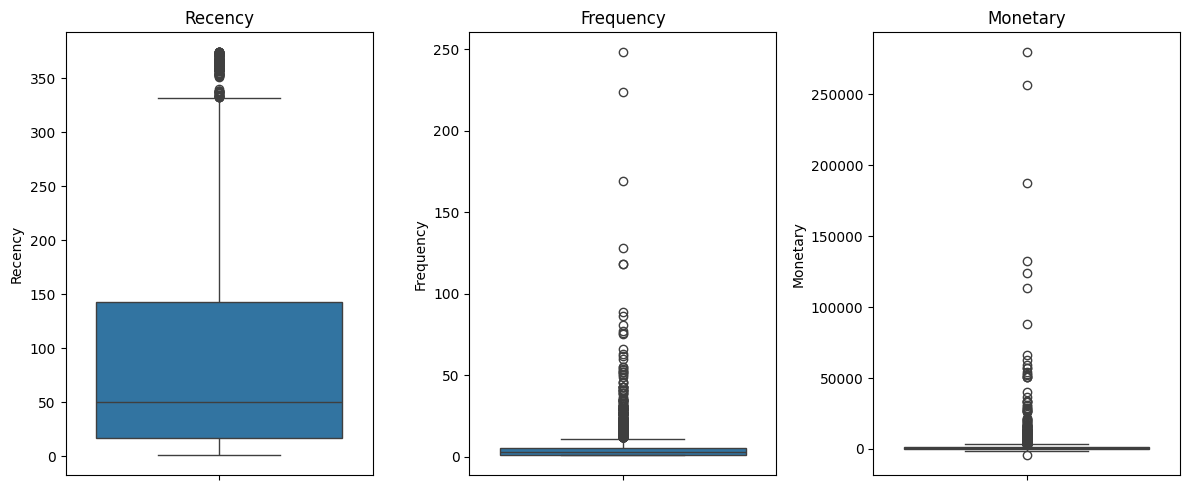

In [ ]:

plt.figure(figsize=(12,5))
for i, col in enumerate(['Recency', 'Frequency', 'Monetary']):
    plt.subplot(1,3,i+1)
    sns.boxplot(y=rfm[col])
    plt.title(col)
plt.tight_layout()
plt.show()

In [ ]:
Q1 = rfm['Recency'].quantile(0.25)
Q3 = rfm['Recency'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

rfm = rfm[(rfm['Recency'] >= lower_bound) & (rfm['Recency'] <= upper_bound)]


In [ ]:
for col in ['Frequency', 'Monetary']:
    upper_limit = rfm[col].quantile(0.99)  # 99th percentile
    rfm[col] = np.where(rfm[col] > upper_limit, upper_limit, rfm[col])


In [ ]:
rfm_log = rfm.copy()
rfm_log['Recency'] = np.log1p(rfm_log['Recency'])
rfm_log['Frequency'] = np.log1p(rfm_log['Frequency'])
rfm_log['Monetary'] = np.log1p(rfm_log['Monetary'])


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


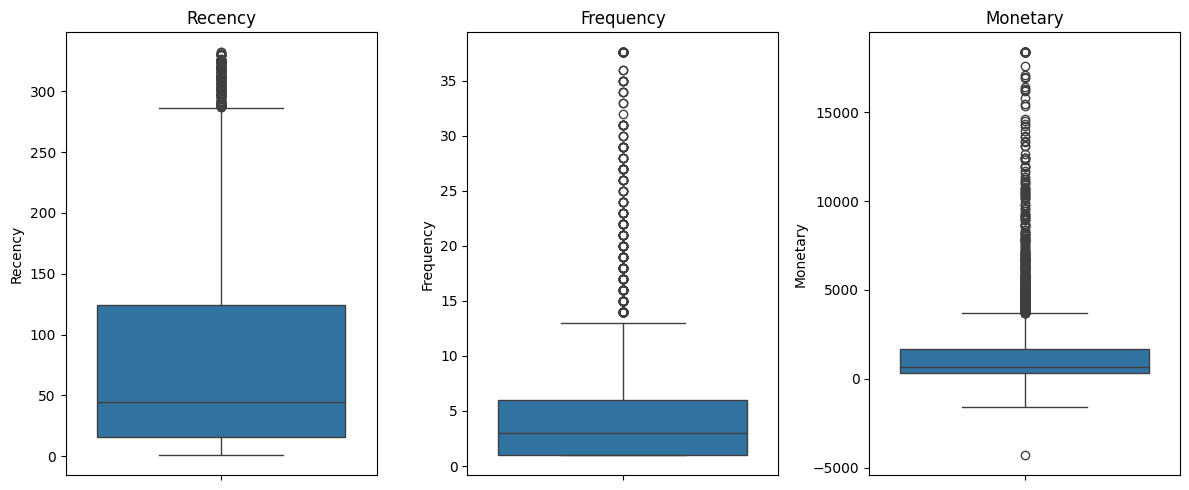

In [ ]:

plt.figure(figsize=(12,5))
for i, col in enumerate(['Recency', 'Frequency', 'Monetary']):
    plt.subplot(1,3,i+1)
    sns.boxplot(y=rfm[col])
    plt.title(col)
plt.tight_layout()
plt.show()

In [ ]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4223 entries, 0 to 4371
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   CustomerID   4223 non-null   float64       
 1   InvoiceDate  4223 non-null   datetime64[ns]
 2   Recency      4223 non-null   int64         
 3   Frequency    4223 non-null   float64       
 4   Monetary     4223 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 198.0 KB


In [ ]:
X=rfm[['Recency','Frequency','Monetary']]

In [ ]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
print(X_scaled.head())


    Recency  Frequency  Monetary
0  2.746025  -0.474801 -0.593050
1 -0.908618   0.346411  1.044590
2 -0.085195  -0.146316  0.089834
3 -0.716862  -0.639043  0.074754
4  2.565549  -0.639043 -0.465991


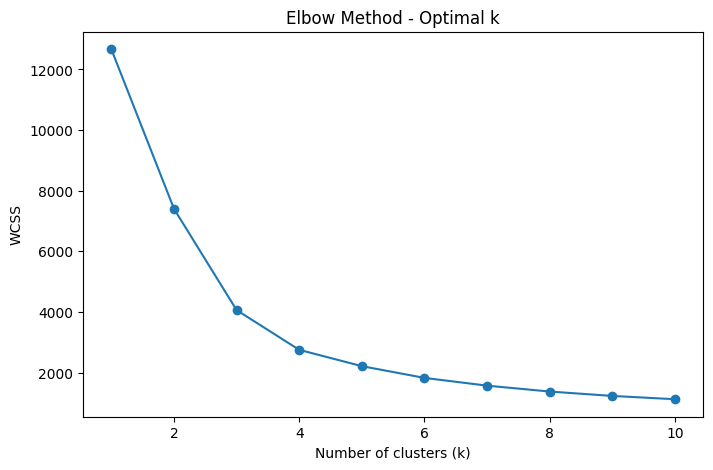

In [ ]:


wcss = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # inertia_ = WCSS

# Plot the Elbow curve
plt.figure(figsize=(8,5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method - Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.show()


In [ ]:


# --- 1. K-Means ---
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# --- 2. Hierarchical (Agglomerative) ---
hier = AgglomerativeClustering(n_clusters=4, linkage='ward')
hier_labels = hier.fit_predict(X_scaled)

# --- 3. DBSCAN ---
dbscan = DBSCAN(eps=1.5, min_samples=5)   # eps & min_samples can be tuned
dbscan_labels = dbscan.fit_predict(X_scaled)

# Function to calculate metrics
def evaluate_clustering(X, labels, name):
    # If only one cluster found, skip metrics
    if len(set(labels)) <= 1:
        return {
            "Model": name,
            "Silhouette": None,
            "CH": None,
            "DB": None
        }
    return {
        "Model": name,
        "Silhouette": silhouette_score(X, labels),
        "CH": calinski_harabasz_score(X, labels),
        "DB": davies_bouldin_score(X, labels)
    }

# Evaluate all models
results = []
results.append(evaluate_clustering(X_scaled, kmeans_labels, "KMeans"))
results.append(evaluate_clustering(X_scaled, hier_labels, "Hierarchical"))
results.append(evaluate_clustering(X_scaled, dbscan_labels, "DBSCAN"))

# Show results
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)


          Model  Silhouette           CH        DB
0        KMeans    0.533162  5076.311465  0.699661
1  Hierarchical    0.446850  3581.721194  0.750406
2        DBSCAN    0.698356    16.974663  0.972564


In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
Y = kmeans.fit_predict(X_scaled)
print(Y)

[0 1 2 ... 2 1 2]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


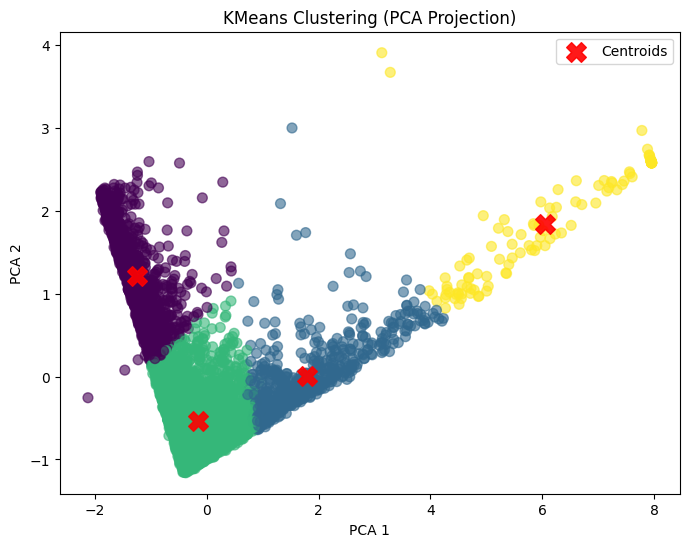

In [ ]:
from sklearn.decomposition import PCA

# Reduce 3D data → 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=Y, cmap='viridis', s=50, alpha=0.6)

# Transform centroids into PCA space
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:,0], centers_pca[:,1], c='red', s=200, alpha=0.9, marker='X', label='Centroids')

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("KMeans Clustering (PCA Projection)")
plt.legend()
plt.show()


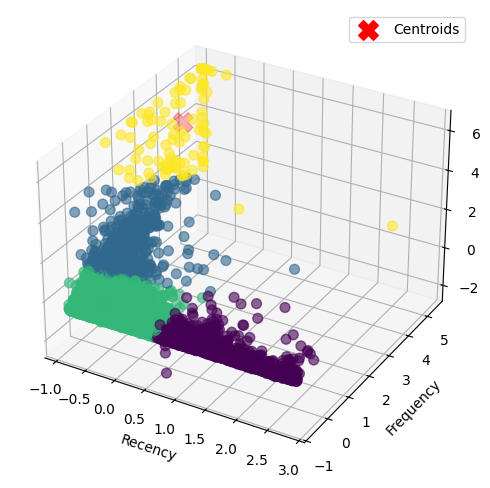

In [ ]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

X_array = np.array(X_scaled)   # convert DataFrame → numpy

ax.scatter(X_array[:,0], X_array[:,1], X_array[:,2],
           c=Y, cmap='viridis', s=50, alpha=0.6)

centers = kmeans.cluster_centers_
ax.scatter(centers[:,0], centers[:,1], centers[:,2],
           c='red', s=200, marker='X', label='Centroids')

ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Moneraty")
ax.legend()
plt.show()
